# Data Filtering
Filtering signals from MIMIC waveform data.

In [1]:
# setup
import sys
import numpy as np
import scipy.signal as sp

from matplotlib import pyplot as plt

import wfdb

# Download records
Identify and download records in the MIMIC III Waveform Database

In [2]:
# Select the first record
selected_record = '3000063_0013'
database_name = 'mimic3wdb/1.0/30/3000063/'
print("Selected record: {}".format(selected_record))

# load data from this record
start_seconds = 0
no_seconds_to_load = 30
fs = 125
record_data = wfdb.rdrecord(record_name = selected_record, sampfrom = fs*start_seconds, sampto = fs*(start_seconds + no_seconds_to_load), pn_dir = database_name) 
print("{} seconds of data loaded from: {}".format(no_seconds_to_load, selected_record))

# Plot the data loaded from this record
# title_text = "First record from " + database_name + " (record: " + selected_record + ")"
# wfdb.plot_wfdb(record=record_data, title=title_text, time_units='seconds') 

Selected record: 3000063_0013
30 seconds of data loaded from: 3000063_0013


# Separate records
Separate ECG, PPG and ABP signals

ECG at position 0
ABP at position 1
PPG at position 2


[Text(0.5, 0, 'Time [s]'), Text(0, 0.5, 'ABP')]

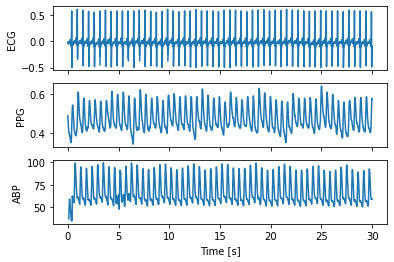

In [3]:
# ECG, PPG and ABP extraction
h = 0
for i in record_data.sig_name:
    if i == 'II':
        print('ECG at position ' + str(h))
        ecg = record_data.p_signal[:,h]
    elif i == 'PLETH':
        print('PPG at position ' + str(h))
        ppg = record_data.p_signal[:,h]
    elif i == 'ABP':
        print('ABP at position ' + str(h))
        abp = record_data.p_signal[:,h]
    else:
        print('Other signal (' + i + ') at position ' + str(h))
    h = h + 1

t = np.arange(0,(no_seconds_to_load - start_seconds),1.0/fs)

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex = True, sharey = False)
ax1.plot(t, ecg)
ax1.set(xlabel = '', ylabel = 'ECG')
ax2.plot(t, ppg)
ax2.set(xlabel = '', ylabel = 'PPG')
ax3.plot(t, abp)
ax3.set(xlabel = 'Time [s]', ylabel = 'ABP')

In [4]:
# Remove NaNs
x, = np.where(np.isnan(ecg))
if len(x) != 0:
    print('NaNs in ECG: ' + str(x))
    for i in x:
        ecg[i] = ecg[i - 1]
x, = np.where(np.isnan(ppg))
if len(x) != 0:
    print('NaNs in PPG: ' + str(x))
    for i in x:
        ppg[i] = ppg[i - 1]
x, = np.where(np.isnan(abp))
if len(x) != 0:
    print('NaNs in ABP: ' + str(x))
    for i in x:
        abp[i] = abp[i - 1]

NaNs in ECG: [ 120  398  745  884 1232]
NaNs in ABP: [ 0  1  2  3  4  5  6  7  8  9 10 11]


# Filter data
Filter ECG signals

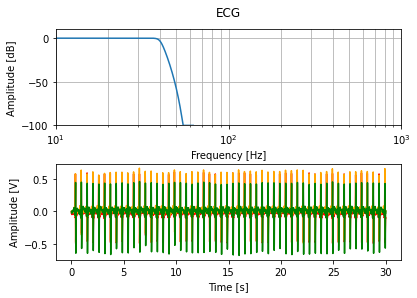

In [5]:
# Filter ECG
sos_ecg = sp.butter(10, [0.5, 40], btype = 'bp', analog = False, output = 'sos', fs = fs)
w, h = sp.sosfreqz(sos_ecg, 2000, fs = fs)
ecg_ff = sp.sosfiltfilt(sos_ecg, ecg)
ecg_f = sp.sosfilt(sos_ecg, ecg)

fig, (ax1,ax2) = plt.subplots(2, 1, sharex = False, sharey = False)
fig.suptitle('ECG')

ax1.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
#ax1.set_title('ECG Butterworth bandpass frequency response')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude [dB]')
ax1.axis((10, 1000, -100, 10))
ax1.grid(which='both', axis='both')

ax2.plot(t, ecg, color = 'red')
ax2.plot(t, ecg_ff, color = 'orange')
ax2.plot(t, ecg_f,  color = 'green')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Amplitude [V]')

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.4, 
                    hspace = 0.4)

#plt.show()

Filter PPG signals

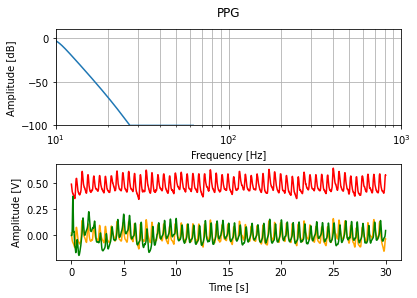

In [6]:
# Filter PPG
sos_ppg = sp.butter(10, [0.2, 10], btype = 'bp', analog = False, output = 'sos', fs = fs)
w, h = sp.sosfreqz(sos_ppg, 2000, fs = fs)
ppg_ff = sp.sosfiltfilt(sos_ppg, ppg)
ppg_f = sp.sosfilt(sos_ppg, ppg)

fig, (ax1,ax2) = plt.subplots(2, 1, sharex = False, sharey = False)
fig.suptitle('PPG')

ax1.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
#ax1.set_title('PPG Butterworth bandpass frequency response')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude [dB]')
ax1.axis((10, 1000, -100, 10))
ax1.grid(which='both', axis='both')

ax2.plot(t, ppg, color = 'red')
ax2.plot(t, ppg_ff, color = 'orange')
ax2.plot(t, ppg_f,  color = 'green')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Amplitude [V]')

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.4, 
                    hspace = 0.4)

#plt.show()

Filter ABP signals

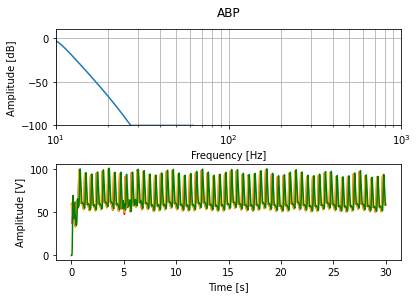

In [7]:
# Filter ABP
sos_abp = sp.butter(10, 10, btype = 'low', analog = False, output = 'sos', fs = fs)
w, h = sp.sosfreqz(sos_abp, 2000, fs = fs)
abp_ff = sp.sosfiltfilt(sos_abp, abp)
abp_f = sp.sosfilt(sos_abp, abp)

fig, (ax1,ax2) = plt.subplots(2, 1, sharex = False, sharey = False)
fig.suptitle('ABP') 

ax1.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
#ax1.set_title('ABP Butterworth bandpass frequency response')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude [dB]')
ax1.axis((10, 1000, -100, 10))
ax1.grid(which = 'both', axis = 'both')

ax2.plot(t, abp, color = 'red')
ax2.plot(t, abp_ff, color = 'orange')
ax2.plot(t, abp_f,  color = 'green')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Amplitude [V]')

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.4, 
                    hspace = 0.4)

#plt.show()
